In [137]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

plt.rcParams.update(plt.rcParamsDefault)

### Code for Exercise 2.5


In [138]:
class NonstationaryBandit:
    def __init__(self, k=10, std_dev=0.01):
        self.k = k
        self.std_dev = std_dev

        self.q_true = np.zeros(k)
        self.optimal_action = 0

    def step(self, action):
        reward = np.random.normal(self.q_true[action], 1.0)

        self.q_true += np.random.normal(0, self.std_dev, self.k)

        self.optimal_action = np.argmax(self.q_true)

        return reward

In [139]:
class SampleAverageAgent:
    def __init__(self, k=10, epsilon=0.1, initial_value=0.0):
        self.k = k
        self.epsilon = epsilon
        self.Q = np.full(k, initial_value)  # Action-value estimates
        self.N = np.zeros(k)  # Action counts

    def select_action(self):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.k)  # Explore
        else:
            return np.argmax(self.Q)  # Exploit

    def update(self, action, reward):
        self.N[action] += 1

        # Q(a) = Q(a) + (1/N(a)) * [R - Q(a)]
        self.Q[action] += (reward - self.Q[action]) / self.N[action]


class ConstantStepAgent:
    def __init__(self, k=10, epsilon=0.1, alpha=0.1, initial_value=0.0):
        self.k = k
        self.epsilon = epsilon
        self.alpha = alpha
        self.Q = np.full(k, initial_value)  # Action-value estimates

    def select_action(self):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.k)  # Explore
        else:
            return np.argmax(self.Q)  # Exploit

    def update(self, action, reward):
        # Q(a) = Q(a) + α * [R - Q(a)]
        self.Q[action] += self.alpha * (reward - self.Q[action])

In [140]:
def run_experiment(agent, bandit, steps=10000):
    rewards = np.zeros(steps)

    optimal_actions = np.zeros(steps)

    for step in range(steps):
        action = agent.select_action()

        reward = bandit.step(action)

        agent.update(action, reward)

        rewards[step] = reward

        optimal_actions[step] = 1 if action == bandit.optimal_action else 0

    return rewards, optimal_actions


def run_multiple_experiments(agent_class, agent_params, n_runs=2000, steps=10000):
    all_rewards = np.zeros((n_runs, steps))
    all_optimal = np.zeros((n_runs, steps))

    for run in range(n_runs):
        bandit = NonstationaryBandit()
        agent = agent_class(**agent_params)

        rewards, optimal_actions = run_experiment(agent, bandit, steps)

        all_rewards[run] = rewards
        all_optimal[run] = optimal_actions

    return all_rewards, all_optimal

In [141]:
print("Running Sample Average Agent")

sample_avg_rewards, sample_avg_optimal = run_multiple_experiments(
    SampleAverageAgent, {"epsilon": 0.1}, n_runs=2000, steps=10000
)

Running Sample Average Agent


In [142]:
print("Running Constant Step-size Agent")

constant_step_rewards, constant_step_optimal = run_multiple_experiments(
    ConstantStepAgent, {"epsilon": 0.1, "alpha": 0.1}, n_runs=2000, steps=10000
)

Running Constant Step-size Agent


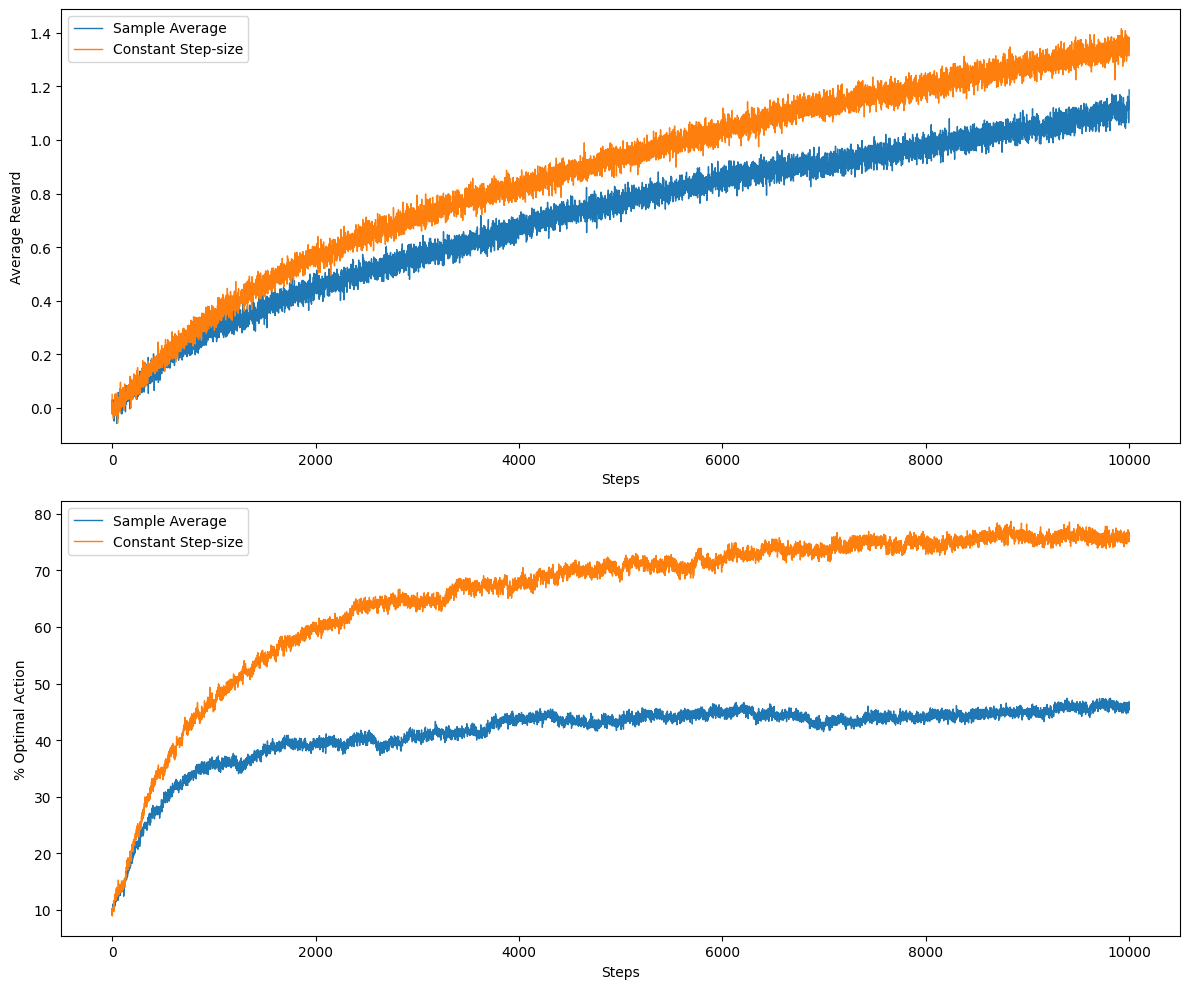

In [143]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(np.mean(sample_avg_rewards, axis=0), label="Sample Average", linewidth=1)
ax1.plot(
    np.mean(constant_step_rewards, axis=0),
    label="Constant Step-size",
    linewidth=1,
)
ax1.set_xlabel("Steps")
ax1.set_ylabel("Average Reward")
ax1.legend()


ax2.plot(np.mean(sample_avg_optimal, axis=0) * 100, label="Sample Average", linewidth=1)
ax2.plot(
    np.mean(constant_step_optimal, axis=0) * 100,
    label="Constant Step-size",
    linewidth=1,
)
ax2.set_xlabel("Steps")
ax2.set_ylabel("% Optimal Action")
ax2.legend()

plt.tight_layout()
plt.show()

### Code for Exercise 2.11


In [168]:
class GradientBanditAgent:
    def __init__(self, k=10, alpha=0.1, baseline=True):
        self.k = k
        self.alpha = alpha
        self.baseline = baseline
        self.H = np.zeros(k)  # Action preferences
        self.avg_reward = 0.0
        self.t = 0

    def select_action(self):
        exp_H = np.exp(self.H - np.max(self.H))  # Subtract max for numerical stability

        self.pi = exp_H / np.sum(exp_H)

        return np.random.choice(self.k, p=self.pi)

    def update(self, action, reward):
        self.t += 1

        if self.baseline:
            self.avg_reward += (reward - self.avg_reward) / self.t

            baseline_reward = self.avg_reward
        else:
            baseline_reward = 0

        for a in range(self.k):
            if a == action:
                self.H[a] += self.alpha * (reward - baseline_reward) * (1 - self.pi[a])
            else:
                self.H[a] -= self.alpha * (reward - baseline_reward) * self.pi[a]


In [173]:
class UCBAgent:
    def __init__(self, k=10, c=2, initial_value=0.0):
        self.k = k
        self.c = c
        self.Q = np.full(k, initial_value)
        self.N = np.zeros(k)
        self.t = 0

    def select_action(self):
        self.t += 1

        # If any action hasn't been selected, choose it
        if np.any(self.N == 0):
            return np.argmin(self.N)

        ucb_values = self.Q + self.c * np.sqrt(np.log(self.t) / self.N)

        return np.argmax(ucb_values)

    def update(self, action, reward):
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]

In [185]:
def run_parameter_study(
    agent_class, param_name, param_values, base_params, n_runs, steps
):
    results = []

    for param_value in param_values:
        print("Running", param_value)

        # Update parameters
        current_params = base_params.copy()
        current_params[param_name] = param_value

        # Run experiments
        all_rewards, _ = run_multiple_experiments(
            agent_class, current_params, n_runs=n_runs, steps=steps
        )

        # Calculate average reward over last 1,000 steps
        avg_reward = np.mean(all_rewards[:, -1000:])
        results.append(avg_reward)

    return results

In [186]:
agents_config = {
    "ε-greedy (sample average)": {
        "class": SampleAverageAgent,
        "param_name": "epsilon",
        "param_values": [1 / 128, 1 / 64, 1 / 32, 1 / 16, 1 / 8, 1 / 4, 1 / 2],
        "base_params": {"epsilon": 0.1},
    },
    "ε-greedy α = 0.1": {
        "class": ConstantStepAgent,
        "param_name": "epsilon",
        "param_values": [1 / 128, 1 / 64, 1 / 32, 1 / 16, 1 / 8, 1 / 4, 1 / 2],
        "base_params": {"alpha": 0.1, "epsilon": 0.1},
    },
    "gradient bandit": {
        "class": GradientBanditAgent,
        "param_name": "alpha",
        "param_values": [1 / 32, 1 / 16, 1 / 8, 1 / 4, 1 / 2, 1],
        "base_params": {"alpha": 0.1},
    },
    "UCB": {
        "class": UCBAgent,
        "param_name": "c",
        "param_values": [1 / 16, 1 / 8, 1 / 4, 1 / 2, 1, 2, 4],
        "base_params": {"c": 2},
    },
    # "greedy with optimistic initialization α = 0.1": {
    #     "class": ConstantStepAgent,
    #     "param_name": "initial_value",
    #     "param_values": [1 / 128, 1 / 64, 1 / 32, 1 / 16, 1 / 8, 1 / 4, 1 / 2, 1, 2, 4],
    #     "base_params": {"alpha": 0.1, "epsilon": 0.0, "initial_value": 0.1},
    # },
}

In [ ]:
results = {}

for agent_name, config in agents_config.items():
    print(agent_name)

    agent_results = run_parameter_study(
        config["class"],
        config["param_name"],
        config["param_values"],
        config["base_params"],
        n_runs=2000,
        steps=2000,
    )

    results[agent_name] = {
        "param_values": config["param_values"],
        "results": agent_results,
    }

ε-greedy (sample average)
Running 0.0078125
Running 0.015625
Running 0.03125
Running 0.0625
Running 0.125
Running 0.25
Running 0.5
ε-greedy α = 0.1
Running 0.0078125
Running 0.015625
Running 0.03125
Running 0.0625
Running 0.125
Running 0.25
Running 0.5
gradient bandit
Running 0.03125
Running 0.0625
Running 0.125
Running 0.25
Running 0.5
Running 1
UCB
Running 0.0625
Running 0.125
Running 0.25
Running 0.5
Running 1
Running 2
Running 4


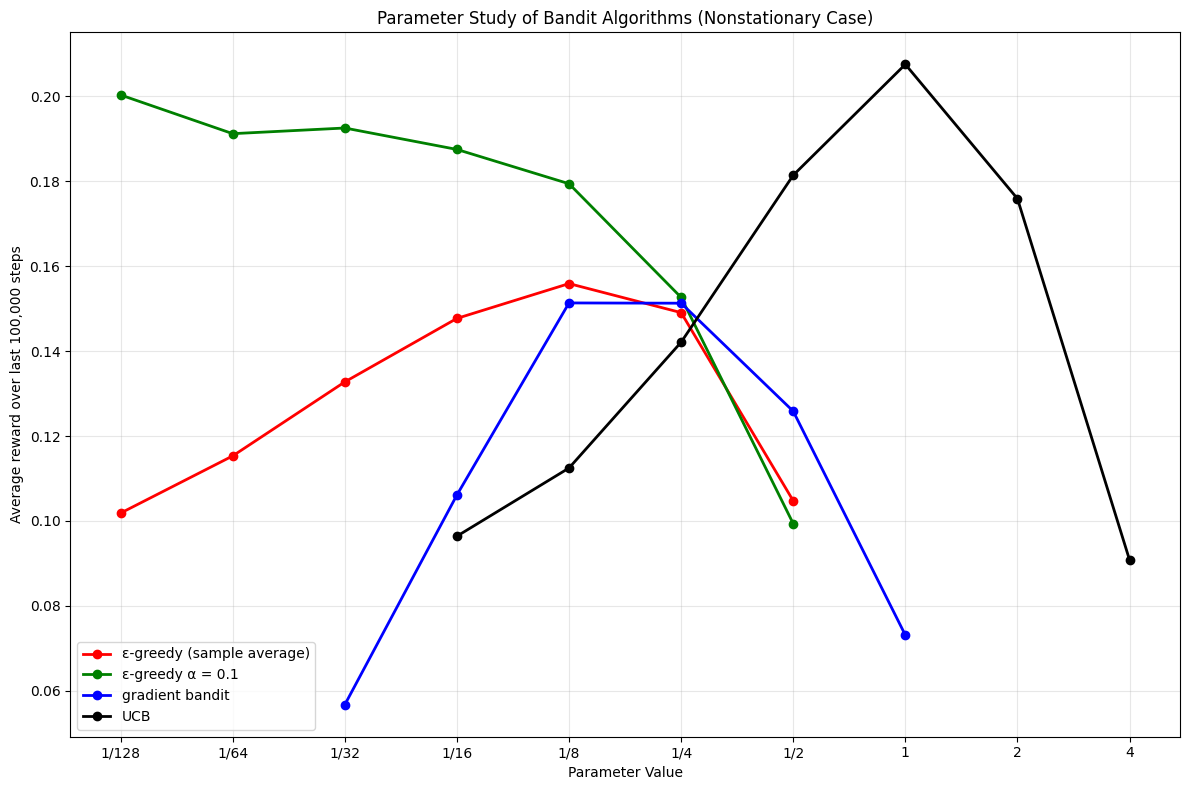

In [189]:
plt.figure(figsize=(12, 8))

colors = ["red", "green", "blue", "black"]

for i, (agent_name, data) in enumerate(results.items()):
    plt.plot(
        data["param_values"],
        data["results"],
        color=colors[i],
        label=agent_name,
        linewidth=2,
        marker="o",
    )

plt.xscale("log", base=2)
plt.xlabel("Parameter Value")
plt.ylabel("Average reward over last 100,000 steps")
plt.title("Parameter Study of Bandit Algorithms (Nonstationary Case)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.xticks(
    [1 / 128, 1 / 64, 1 / 32, 1 / 16, 1 / 8, 1 / 4, 1 / 2, 1, 2, 4],
    ["1/128", "1/64", "1/32", "1/16", "1/8", "1/4", "1/2", "1", "2", "4"],
)

plt.tight_layout()
plt.show()